# Modèle de **mélanges gaussiens** pour la génération de données
## 1 Modèle de mélange

* Soit $Z\in\{1,\dots,K\}$ telle que $\mathbb{P}[Z=k]=\pi_k$ avec $\sum_{k=1}^K\pi_k=1$ ;
* Soit $X\in\mathbb R^d$ telle que, conditionnellement à $Z=k$,  
  $$X\mid Z=k\;\sim\;\mathcal N(\mu_k,\Sigma_k)$$  
  où $\mu_k\in\mathbb R^d$ et $\Sigma_k\in\mathbb R^{d\times d}$ est définie positive.
* On considère un modèle de mélange de gaussien definit (pour un K fixé) par:
 $$\theta = (\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma}) = ((\pi_1, ..., \pi_K),(\mu_1, ..., \mu_K),(\Sigma_1, ..., \Sigma_K))$$


### T1
---  
On sait que $\mathbb{P}[Z=k] = \pi_k$

Soit $f_k(x;\mu_k,\Sigma_k) = \frac{1}{(2\pi)^{k/2}\,|\Sigma|^{1/2}}\,
\exp\!\bigl[-\tfrac12\,(x-\mu)^\top \Sigma^{-1}(x-\mu)\bigr],\qquad x \in \mathbb R$

Donc, $f_k(x;\mu_k,\Sigma_k) = f_{X\mid Z = k}(x )$
  
Par la loi totale de probabilité appliquée aux densités :

$f_X(x)=\sum_{k=1}^K \mathbb{P}[Z=k] \; f_{X\mid Z}(x\mid k)=\sum_{k=1}^K \pi_l f_{\mu_k,\Sigma_l}(x).$
   
La somme finie de densités, pondérée par des poids positifs qui somment à 1, est bien une densité (positive partout et intégrale égale à 1).

### S1
---

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import math
import sklearn.datasets

rng = np.random.default_rng(42)

In [8]:
class GaussianMixtureModel:
    d: int
    weights: np.ndarray
    means: np.ndarray
    covariances: np.ndarray
    def __init__(self, d):
        self.d = d
    
    def set_params(self, weights, means, covariances):
        if len(means[0]) != self.d or len(covariances[0]) != self.d:
            raise ValueError(f"Length of weights, means, and covariances must match {self.d}.")
        if len(weights) != len(means) or len(weights) != len(covariances):
            raise ValueError("Weights, means, and covariances must have the same number of components.")
        self.weights = np.array(weights)
        self.means = np.array(means)
        self.covariances = np.array(covariances)

In [9]:
def plot_multivariate_normal(K, theta, n):
    Z = rng.choice(K, size=n, p=theta.weights) # K will be 1 unity less than the real index of the model 
    X = np.zeros((n, K - 1))
    for k in range(K):
        indices = np.where(Z == k)[0]
        for index in indices:
            X[index] = rng.multivariate_normal(theta.means[k], theta.covariances[k])
    return X, Z


Text(0.5, 1.0, 'Multivariate Normal Samples from GMM')

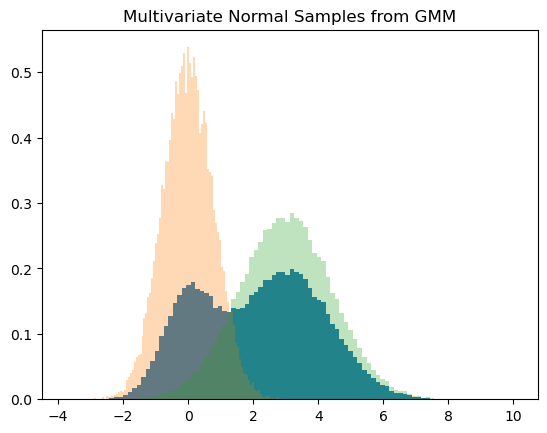

In [10]:
gmm = GaussianMixtureModel(d=1)
gmm.set_params(
    weights=[0.3, 0.7],
    means=[[0], [3]], 
    covariances=np.array([[[0.6]], [[2.0]]])
)
data, Z = plot_multivariate_normal(2, gmm, 100000)
plt.hist(data, bins=100, density=True)
X1 = data[Z == 0]
X2 = data[Z == 1]
plt.hist(X1, bins=100, density=True, alpha=0.3, label='Component 1')
plt.hist(X2, bins=100, density=True, alpha=0.3, label='Component 2')
plt.title('Multivariate Normal Samples from GMM')

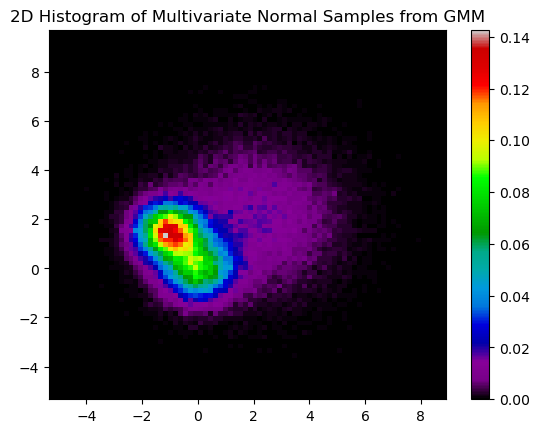

In [11]:
gmm = GaussianMixtureModel(d=2)
gmm.set_params(
    weights=[0.3, 0.3, 0.4],
    means=[[0, 0], [2, 2], [-1, 1.5]], 
    covariances=np.array([[[0.6, 0], [0, 0.6]], [[3.0, 0], [0, 3.0]], [[0.5, 0], [0, 0.5]]])
)
data, Z = plot_multivariate_normal(3, gmm, 100000)
# plt.hist(X[:,0], bins=100, density=True)
# plt.title('distribution of first dimension for d = 2')
# plt.show()
plt.hist2d(data[:,0], data[:,1], bins=(80,80), density=True, cmap = plt.cm.nipy_spectral)
plt.colorbar()
plt.title('2D Histogram of Multivariate Normal Samples from GMM')
plt.show()

## 2 Algorithme d'estimation

* Soit $Z\in\{1,\dots,K\}$ telle que $\mathbb{P}[Z=k]=\pi_k$ avec $\pi_k0$ et $\sum_{k=1}^K\pi_k=1$ ;
* Soit $X\in\mathbb R^d$ telle que, conditionnellement à $Z=k$,  
  $$X\mid Z=k\;\sim\;\mathcal N(\mu_k,\Sigma_k)$$  
  où $\mu_k\in\mathbb R^d$ et $\Sigma_k\in\mathbb R^{d\times d}$ est définie positive.
* On considère un modèle de mélange de gaussien definit (pour un K fixé) par:
 $$\theta = (\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma}) = ((\pi_1, ..., \pi_K),(\mu_1, ..., \mu_K),(\Sigma_1, ..., \Sigma_K))$$


In [12]:
def vraisemblance(k, X, theta):
    vraisemblance = 0.0
    for j in range(k):
        multinormal = multivariate_normal(mean=theta.means[j], cov=theta.covariances[j])
        for point in X:
            vraisemblance += math.log(multinormal.pdf(point) * theta.weights[j])


    return vraisemblance

### T2

Calcul de la densité $p_{\theta}$ du couple $(Z,X)$:

Par définition, pour  $k \in \{1, ... , K\}$  la variable  $X \mid Z = k$  suit une loi normale de paramètre  $(\mu_{k},\Sigma_{k})$ de fonction de répartition $f_{\mu_k, \Sigma_k}$.

Soit $k \in \{1, ..., K\}$  et  $x \in \mathbb{R}$

Par définition de la fonction densité conditionnelle : $$f_{X \mid Z = k}(x) = \frac{p_{\theta}(k,x)}{\mathbb{P}_{\theta}(Z = k)}$$

Or $\mathbb{P}_{\theta}(Z = k) = \pi_k$

Donc $$p_{\theta}(k,x) = \pi_k f_{\mu_k,\Sigma_k}(x)$$
 

### T3

Soit $k \in \{1, ..., K\}$  et  $x \in \mathbb{R}$

Par définition  $\mathbb(P)_{\theta}(Z = k \mid X = x) = \frac{p_{\theta}(k,x)}{f_X(x)}$

On substitue alors les expressions au numérateur et au dénominateur obtenues respectivement en T2 et T1.

Ainsi $$\mathbb{P}_{\theta}(Z = k \mid X = x) = \frac{ \pi_k f_{\mu_k,\Sigma_k}(x) }{ \sum_{l=1}^K \pi_l f_{\mu_l,\Sigma_l}(x) }$$


### T4



In [13]:
def thetaEstimation(data, clusters, k):
    if len(clusters) != len(data):
        raise ValueError("The number of clusters must match the number of data points.")

    weights = np.zeros(k)
    means = np.zeros((k, data.shape[1]))
    covariances = np.zeros((k, data.shape[1], data.shape[1]))

    for cluster in range(k):
        idx = np.where(clusters == cluster)[0]
        if len(idx) == 0:
            means[cluster] = np.zeros(data.shape[1])
            covariances[cluster] = np.eye(data.shape[1])
            continue
        weights[cluster] = len(idx) / len(clusters)
        means[cluster] = np.mean(data[idx], axis=0)
        covariances[cluster] = np.cov(data[idx].T, bias=True)
        

    gmm = GaussianMixtureModel(data.shape[1])
    gmm.set_params(weights, means, covariances)
    return gmm


In [14]:
def clustersEstimation(data, theta, k):
    clusters = np.zeros(len(data))
    vraisemblances = np.zeros(k)
    for i in range(len(data)):
        point = data[i]
        for j in range(k):
            vraisemblances[j] = multivariate_normal.pdf(point, mean=theta.means[j], cov=theta.covariances[j]) * theta.weights[j]
        clusters[i] = np.argmax(vraisemblances)
    return clusters
        
            


In [15]:
def initialEstimation(data, k, loops = 5):
    centres = data[:k]
    zInitial = np.zeros(len(data))
    for i in range(loops):
        for i in range(len(data)):
            distances = np.zeros(len(centres))
            for j in range(len(centres)):
                distances[j] = np.linalg.norm(data[i] - centres[j])
            if distances[0] <= distances[1] and distances[0] <= distances[2]:
                zInitial[i] = 0
            elif distances[1] <= distances[2]:
                zInitial[i] = 1
            else:
                zInitial[i] = 2
        centres = np.mean(data[zInitial == 0], axis=0), np.mean(data[zInitial == 1], axis=0), np.mean(data[zInitial == 2], axis=0)
    return zInitial

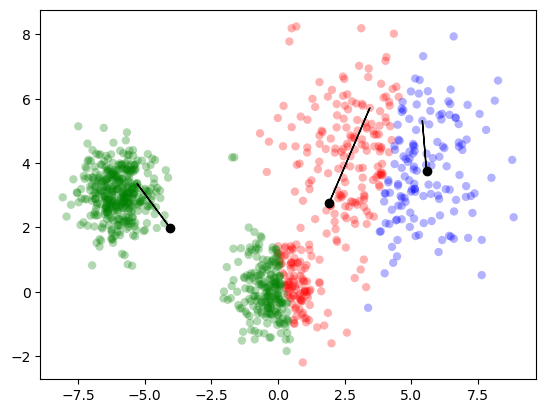

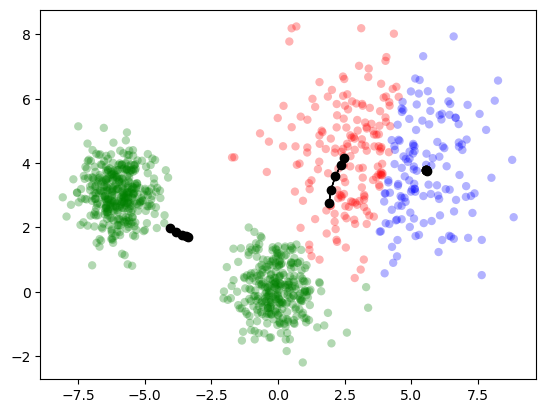

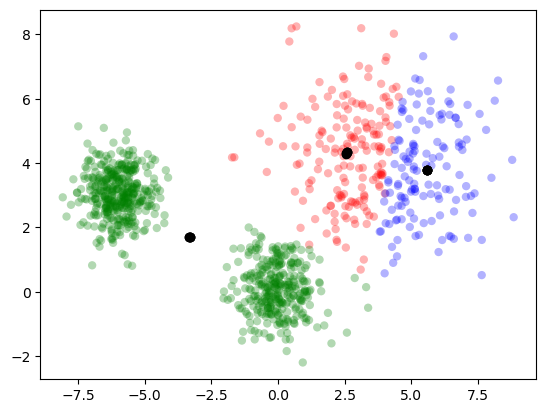

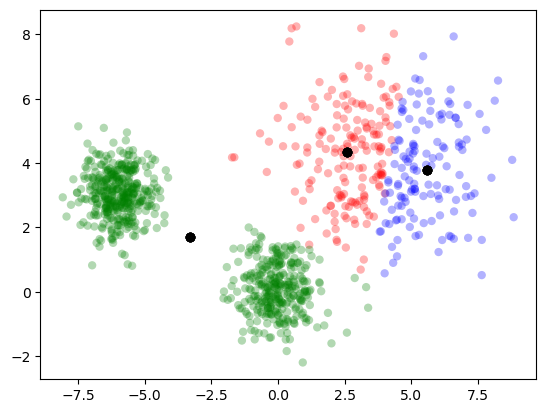

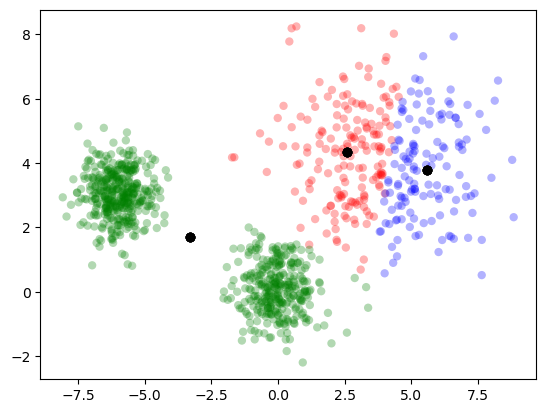

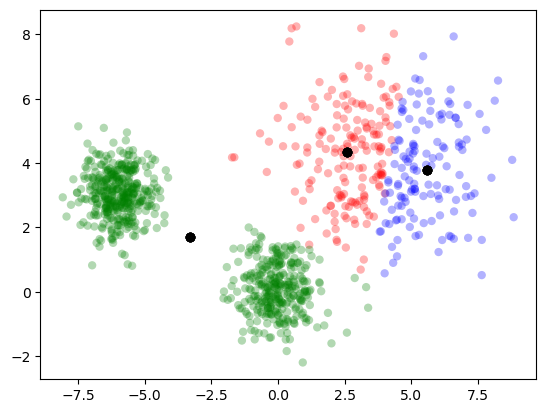

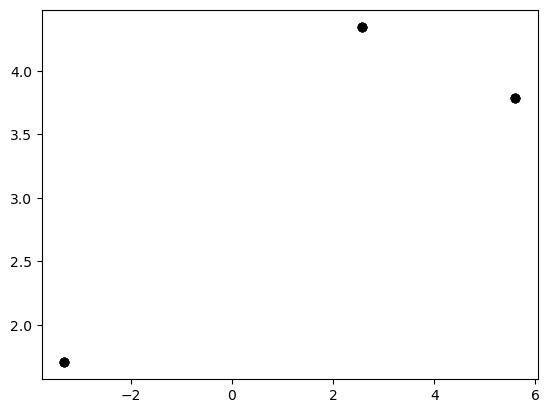

In [ ]:
Test_skLearn = False
PlotClusters = True

if Test_skLearn:
    data = sklearn.datasets.make_blobs(centers=3, n_samples=1000)[0]
else:
    gmm = GaussianMixtureModel(d=2)
    gmm.set_params(
        weights=[0.3, 0.3, 0.4],
        means=[[0, 0], [4, 4], [-6.0, 3.0]], 
        covariances=np.array([[[0.6, 0], [0, 0.6]], [[3.0, 0], [0, 3.0]], [[0.5, 0], [0, 0.5]]])
    )
    data, Z = plot_multivariate_normal(3, gmm, 1000)
    
z = initialEstimation(data, 3, 1)
theta = thetaEstimation(data, z, 3)

meansPrev = data[:3]
plt.scatter(meansPrev[:,0], meansPrev[:, 1], color='black', marker='o', label='Means', zorder = 1)

for _ in range(30):
    plt.scatter(theta.means[:, 0], theta.means[:, 1], color='black', marker='o', label='Means', zorder = 1)
    for i in range(3):
        plt.arrow(meansPrev[i,0], meansPrev[i, 1], (theta.means[i, 0] - meansPrev[i,0]), (theta.means[i, 1] - meansPrev[i,1]), zorder = 1)
    
    if _ % 5 == 0 and PlotClusters:
        color_map = {0: 'red', 1: 'green', 2: 'blue'}
        for i in range(3):
            for j in range(len(data)):
                if z[j] == i:
                    plt.scatter(data[j,0], data[j,1], color=color_map[i], edgecolors = 'none', label=f'Cluster {i}', alpha=0.3, zorder = -1)
        plt.show()

    meansPrev = theta.means.copy()
    theta = thetaEstimation(data, z, 3)
    z = clustersEstimation(data, theta, 3)
